In [1]:

import pandas as pd
import numpy as np
import requests
import io
import time
import os 
import sys
current = os.getcwd()
parent = os.path.dirname(current)
sys.path.append(parent)
from  Datasets.get_pubchem_assay import load_csv_data_from_a_PubChem_assay, drop_sids_with_no_cids, download_smiles_given_cids_from_pubmed, load_smiles_and_activity_targets_from_a_PubChem_assay
from Pipelines.SmilestoMaccs import SmitoMACCS
from Pipelines.SmilestoNxgraphs import SmitoNxGraphs
from Pipelines.NxGraphstoGraph2Vect import  NxGraphstoGraph2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from General.downsample_data import downsample_binary_data
from Arhitectures.utils import get_report
import warnings
warnings.filterwarnings("ignore")

#  Get Data

In [2]:

X,y=load_smiles_and_activity_targets_from_a_PubChem_assay(1345084)
X,y=np.array(X),np.array(y)
     

61765


# Downsampling

In [4]:
X,y=downsample_binary_data(X,y)

# inactives :  338
# actives   :  338
676 676


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, shuffle=True, random_state=3100, stratify=y, test_size=0.2)

print(X_train.shape, X_test.shape)
print(len(y_train), len(y_test))
print(np.sum(y_train), np.sum(y_test))

(540,) (136,)
540 136
270 68


In [6]:
clf = RandomForestClassifier(criterion='gini', max_depth=7, n_estimators= 227)
pipe = Pipeline([('scaler', SmitoMACCS()), ('rf', clf)])
result=pipe.fit(X_train,y_train)
result.score(X_test, y_test)


0.8382352941176471

In [3]:
# correct solution:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

In [7]:

clf = RandomForestClassifier(max_depth=7, random_state=0)
pipe = Pipeline([('graphicalizer', SmitoNxGraphs()), ('vectorizer', NxGraphstoGraph2Vec()), ('clf', clf)])
result=pipe.fit(X_train,y_train)
y_pred=result.predict(X_test)
y_pred_score=result.predict_proba(X_test)
result.score(X_test, y_test)


0.5147058823529411

In [8]:
y_pred_score=np.max(result.predict_proba(X_test), axis=1)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        68
           1       0.50      1.00      0.67        68

    accuracy                           0.50       136
   macro avg       0.25      0.50      0.33       136
weighted avg       0.25      0.50      0.33       136



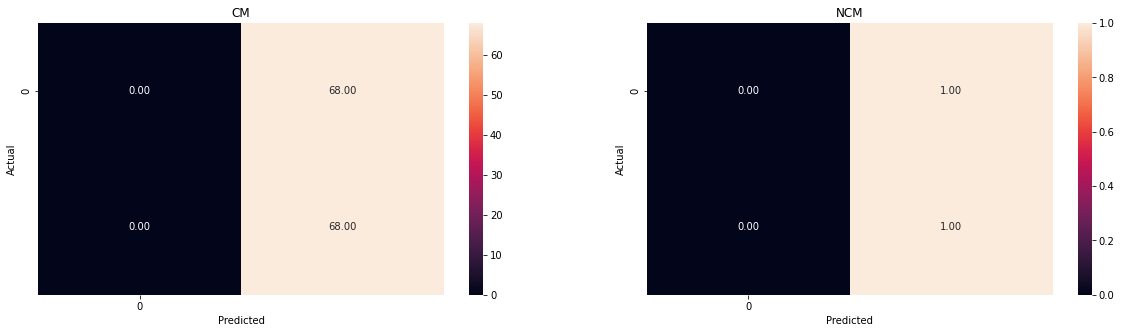

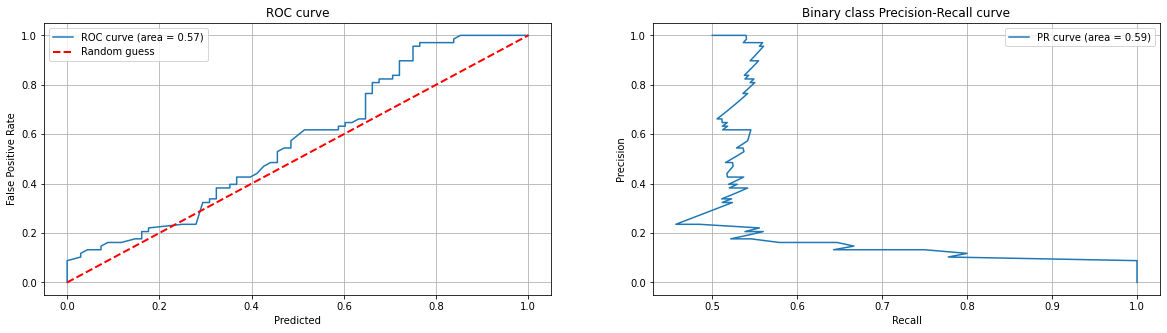

In [9]:
get_report(y_test, (y_pred),y_pred_score)